In [2]:
import sys
sys.path.append('.')

import gym
import numpy as np
from itertools import count
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import random
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from utils import RAdam

def moving_average(x, N):
    return np.convolve(x, np.ones(N, ), mode='valid') / N

Episode 99 finished after 126 timesteps
Episode 199 finished after 299 timesteps
Episode 299 finished after 148 timesteps
Episode 399 finished after 238 timesteps
Episode 499 finished after 135 timesteps
Episode 599 finished after 201 timesteps
Episode 699 finished after 244 timesteps
Episode 799 finished after 135 timesteps
Episode 899 finished after 186 timesteps
Episode 999 finished after 500 timesteps
Episode 1099 finished after 302 timesteps
Episode 1199 finished after 287 timesteps
Episode 1299 finished after 222 timesteps
Episode 1399 finished after 239 timesteps
Episode 1499 finished after 407 timesteps
Episode 99 finished after 18 timesteps
Episode 199 finished after 33 timesteps
Episode 299 finished after 24 timesteps
Episode 399 finished after 109 timesteps
Episode 499 finished after 396 timesteps
Episode 599 finished after 500 timesteps
Episode 699 finished after 161 timesteps
Episode 799 finished after 131 timesteps
Episode 899 finished after 76 timesteps
Episode 999 finis

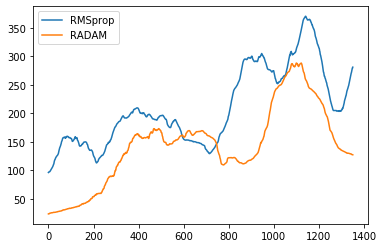

In [2]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(4, 128)
        self.action_head = nn.Linear(128, 2)
        self.value_head = nn.Linear(128, 1)

        self.saved_actions = []
        self.rewards = []
        self.dones = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores, dim=-1), state_values

SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])

policy = Policy()
optimizer = optim.RMSprop(policy.parameters(), lr=3e-3)
# optimizer = RAdam(policy.parameters(), lr=3e-3)
eps = np.finfo(np.float32).eps.item()

def select_action(state):
    state = torch.from_numpy(state).float()
    probs, state_value = policy(state)
    m = Categorical(probs)
    action = m.sample()
    policy.saved_actions.append(SavedAction(m.log_prob(action), state_value))
    return action.item()

"GIVEN rewards array from rollout return the returns with zero mean and unit std"        
def discount_rewards(rewards_arr, dones, gamma, final_value=0):
    R = final_value
    returns = []
    zipped = list(zip(rewards_arr, dones))
    for (r, done) in zipped[::-1]:
        if done:
            R = 0
        R = r + R*gamma
        returns.insert(0, R)
#     print('rewards_arr', rewards_arr)
    returns = torch.tensor(returns)
    return (returns - returns.mean())/(returns.std() + eps)

def reset_globals():
    global policy
    global optimizer
    
    policy = Policy()
    optimizer = optim.RMSprop(policy.parameters(), lr=3e-3)

def train_on_rollout(gamma=0.99):
    returns = discount_rewards(policy.rewards, gamma)
    actor_loss = []
    critic_loss = []
    for (log_prob, value), r in zip(policy.saved_actions, returns):
        advantage = r - value.item()
        actor_loss.append(-log_prob * advantage)
        critic_loss.append(F.smooth_l1_loss(value, torch.tensor([r])))
    optimizer.zero_grad()
    loss = torch.stack(actor_loss).sum() + torch.stack(critic_loss).sum()
    loss.backward()
    optimizer.step()
    del policy.rewards[:]
    del policy.saved_actions[:]
    
def train_on_batch(gamma=0.99, final_obs=None, done=True):
    state = torch.from_numpy(final_obs).float()
    _, state_value = policy(state)
    final_value = state_value.detach() if not done else 0.0
    
    returns = discount_rewards(policy.rewards, policy.dones, gamma, final_value)
    actor_loss = []
    critic_loss = []
    for (log_prob, value), r in zip(policy.saved_actions, returns):
        advantage = r - value.item()
        actor_loss.append(-log_prob * advantage)
        critic_loss.append(F.smooth_l1_loss(value, torch.tensor([r])))
    optimizer.zero_grad()
    loss = torch.stack(actor_loss).sum() + torch.stack(critic_loss).sum()
    loss.mean().backward()
    optimizer.step()
    del policy.rewards[:]
    del policy.saved_actions[:]
    del policy.dones[:]

def learn_n_step_A2C(N_eps=500, max_ep_steps=500):
    df = 0.99
    rewards = []
    env = gym.make('CartPole-v0')
    env._max_episode_steps = max_ep_steps
    T = 0
    batch_update_freq = 30

    for i_episode in range(N_eps):
        observation = env.reset()
        total_r = 0
        for t in range(100000):
            T += 1
            action = select_action(observation)
            observation, reward, done, info = env.step(action)
            policy.rewards.append(reward)
            policy.dones.append(done)
            total_r += reward
            if T % batch_update_freq == 0:
                train_on_batch(0.99, observation, done=True)
            if done:
#                 train_on_batch(0.99, observation, done)
                if (i_episode + 1) % 100 == 0:                
                    print("Episode {} finished after {} timesteps".format(i_episode, t+1))
                break
        rewards.append(total_r)
    env.close()
    return rewards
N_EPS = 1500
rewards_A2C_RMs_prop = learn_n_step_A2C(N_EPS, 500)
plt.plot(moving_average(rewards_A2C_RMs_prop, 150), label='RMSprop')
# Try out radam
reset_globals()
optimizer = RAdam(policy.parameters(), lr=3e-3)
rewards_A2C_RADAM = learn_n_step_A2C(N_EPS, 500)
plt.plot(moving_average(rewards_A2C_RADAM, 150), label='RADAM')
plt.legend()
plt.show()

## PPO:

<img src="./asd.png" style="width: 70%"> </img>

In [28]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(4, 128)
        self.action_head = nn.Linear(128, 2)
        self.value_head = nn.Linear(128, 1)

        self.actions = []
        self.logprobs = []
        self.rewards = []
        self.dones = []
        self.states = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores, dim=-1), state_values.squeeze()

policy = Policy()
policy_old = Policy()
policy_old.load_state_dict(policy.state_dict())

optimizer = optim.RMSprop(policy.parameters(), lr=3e-3)
# optimizer = RAdam(policy.parameters(), lr=3e-3)
eps = np.finfo(np.float32).eps.item()

def reset_globals():
    global policy
    global policy_old
    global optimizer
    
    policy = Policy()
    policy_old = Policy()
    policy_old.load_state_dict(policy.state_dict())
    
    optimizer = optim.RMSprop(policy.parameters(), lr=3e-3)


def select_action(state):
    state = torch.from_numpy(state).float()
    probs, state_value = policy_old(state)
    m = Categorical(probs)
    action = m.sample()
    policy.actions.append(action.item())
    policy.logprobs.append(m.log_prob(action).item())
    policy.states.append(state)
#     policy.saved_actions.append(SavedAction(m.log_prob(action), state_value))
    return action.item()

"GIVEN rewards array from rollout return the returns with zero mean and unit std"        
def discount_rewards(rewards_arr, dones, gamma, final_value=0):
    R = final_value
    returns = []
    zipped = list(zip(rewards_arr, dones))
    for (r, done) in zipped[::-1]:
        if done:
            R = 0
        R = r + R*gamma
        returns.insert(0, R)
    returns = torch.tensor(returns)
    return (returns - returns.mean())/(returns.std() + eps)

def evaluate_policy(states, old_actions):
    probs, values = policy.forward

def batch_update_agent(gamma=0.99, final_obs=None, done=True):
    state = torch.from_numpy(final_obs).float()
    _, state_value = policy(state)
    final_value = state_value.detach() if not done else 0.0
    returns = discount_rewards(policy.rewards, policy.dones, gamma, final_value)
    
    states = torch.stack(policy.states).float()
#     print(states.shape)
    old_actions = policy.actions
#     print(old_actions)
    old_logprobs = torch.tensor(policy.logprobs).float()
#     print(old_logprobs.shape)
    
    # PPO OLD VALUES
    for i in range(2):
        # Calculate needed values    
        p, v = policy.forward(states)
        m = Categorical(p)
        c = m.log_prob(torch.tensor(old_actions))
        entr = m.entropy()

        # value fn loss
        loss_vf = F.mse_loss(v, returns)

        # surrogate loss
        advantage = returns - v.detach()
        r_ts = torch.exp(c - old_logprobs)
        loss_surr = - (torch.min(r_ts * advantage, torch.clamp(r_ts, 1-0.2, 1+0.2) * advantage)).mean()
        
        # maximize entropy bonus
        loss_entropy = - 0.0001 * entr.mean()

        # the total_loss
        loss_total = loss_vf + loss_surr + loss_entropy
        
        # step
        optimizer.zero_grad()
        loss_total.backward()
        optimizer.step()
#         raise Exception('1111')

    policy_old.load_state_dict(policy.state_dict())    
    
    del policy.actions[:]
    del policy.states[:]
    del policy.logprobs[:]
    del policy.rewards[:]
    del policy.dones[:]

def learn_PPO_single_threaded(N_eps=500, max_ep_steps=500):
    df = 0.99
    rewards = []
    env = gym.make('CartPole-v0')
    env._max_episode_steps = max_ep_steps
    T = 0
    batch_update_freq = 300

    for i_episode in range(N_eps):
        observation = env.reset()
        total_r = 0
        for t in range(100000):
            T += 1
            action = select_action(observation)
            observation, reward, done, info = env.step(action)
            total_r += reward
            if done:
                reward = total_r
            else:
                reward = 0
            policy.rewards.append(reward)
            policy.dones.append(done)
            if T % batch_update_freq == 0:
                batch_update_agent(df, observation, done=True)
            if done:
#                 train_on_batch(0.99, observation, done)
                if (i_episode + 1) % 100 == 0:                
                    print("Episode {} finished after {} timesteps".format(i_episode, t+1))
                break
        rewards.append(total_r)
    env.close()
    return rewards

# N_EPS = 1500
N_EPS = 1000
rewards_PPO = learn_PPO_single_threaded(N_EPS, 500)
# plt.plot(moving_average(rewards_PPO, 150), label='RMSprop')

# # Try out radam
# reset_globals()

# optimizer = RAdam(policy.parameters(), lr=3e-3)
# rewards_PPO_RAdam = learn_PPO_single_threaded(N_EPS, 500)
# plt.plot(moving_average(rewards_PPO_RAdam, 150), label='RAdam')
# plt.legend()
# plt.show()

Episode 99 finished after 14 timesteps
Episode 199 finished after 47 timesteps
Episode 299 finished after 63 timesteps
Episode 399 finished after 31 timesteps
Episode 499 finished after 51 timesteps
Episode 599 finished after 39 timesteps
Episode 699 finished after 51 timesteps
Episode 799 finished after 55 timesteps
Episode 899 finished after 38 timesteps
Episode 999 finished after 25 timesteps


Episode 99 finished after 56 timesteps
Episode 199 finished after 500 timesteps
Episode 299 finished after 500 timesteps
Episode 399 finished after 500 timesteps
Episode 499 finished after 500 timesteps
Episode 599 finished after 500 timesteps
Episode 699 finished after 493 timesteps
Episode 799 finished after 500 timesteps
Episode 899 finished after 500 timesteps
Episode 999 finished after 500 timesteps


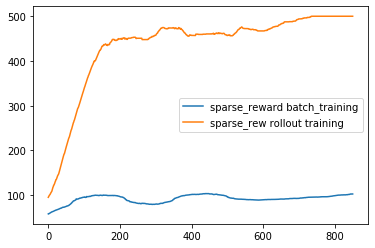

In [56]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(4, 128)
        self.action_head = nn.Linear(128, 2)
        self.value_head = nn.Linear(128, 1)

        self.actions = []
        self.logprobs = []
        self.rewards = []
        self.dones = []
        self.states = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores, dim=-1), state_values.squeeze()

policy = Policy()
policy_old = Policy()
policy_old.load_state_dict(policy.state_dict())

optimizer = optim.RMSprop(policy.parameters(), lr=3e-3)
# optimizer = RAdam(policy.parameters(), lr=3e-3)
eps = np.finfo(np.float32).eps.item()

def reset_globals():
    global policy
    global policy_old
    global optimizer
    
    policy = Policy()
    policy_old = Policy()
    policy_old.load_state_dict(policy.state_dict())
    
    optimizer = optim.RMSprop(policy.parameters(), lr=3e-3)


def select_action(state):
    state = torch.from_numpy(state).float()
    probs, state_value = policy_old(state)
    m = Categorical(probs)
    action = m.sample()
    policy.actions.append(action.item())
    policy.logprobs.append(m.log_prob(action).item())
    policy.states.append(state)
#     policy.saved_actions.append(SavedAction(m.log_prob(action), state_value))
    return action.item()

"GIVEN rewards array from rollout return the returns with zero mean and unit std"        
def discount_rewards(rewards_arr, dones, gamma, final_value=0):
    R = final_value
    returns = []
    zipped = list(zip(rewards_arr, dones))
    for (r, done) in zipped[::-1]:
        if done:
            R = 0
        R = r + R*gamma
        returns.insert(0, R)
    returns = torch.tensor(returns)
    return (returns - returns.mean())/(returns.std() + eps)

def evaluate_policy(states, old_actions):
    probs, values = policy.forward

def batch_update_agent(n_epochs, gamma=0.99, final_obs=None, done=True):
    state = torch.from_numpy(final_obs).float()
    _, state_value = policy(state)
    final_value = state_value.detach() if not done else 0.0
    returns = discount_rewards(policy.rewards, policy.dones, gamma, final_value)
    
    states = torch.stack(policy.states).float()
#     print(states.shape)
    old_actions = policy.actions
#     print(old_actions)
    old_logprobs = torch.tensor(policy.logprobs).float()
#     print(old_logprobs.shape)
    
    # PPO OLD VALUES
    batch_size = 64
    n_iterations = int(len(states)/64 * n_epochs)
    
    for i in range(n_iterations):
        idxs = np.random.randint(0, len(states), batch_size)
        np.random.randint
        # Calculate needed values    
        p, v = policy.forward(states[idxs])
        m = Categorical(p)
#         print(old_actions)
        c = m.log_prob(torch.tensor(old_actions)[idxs])
        entr = m.entropy()

        # value fn loss
        loss_vf = F.mse_loss(v, returns[idxs])

        # surrogate loss
        advantage = returns[idxs] - v.detach()
        r_ts = torch.exp(c - old_logprobs[idxs])
        loss_surr = - (torch.min(r_ts * advantage, torch.clamp(r_ts, 1-0.2, 1+0.2) * advantage)).mean()
        
        # maximize entropy bonus
        loss_entropy = - 0.0001 * entr.mean()

        # the total_loss
        loss_total = loss_vf + loss_surr + loss_entropy
        
        # step
        optimizer.zero_grad()
        loss_total.backward()
        optimizer.step()
#         raise Exception('1111')

    policy_old.load_state_dict(policy.state_dict())    
    
    del policy.actions[:]
    del policy.states[:]
    del policy.logprobs[:]
    del policy.rewards[:]
    del policy.dones[:]

def learn_PPO_GAE_sparse_reward(N_eps=500, max_ep_steps=500):
    df = 0.99
    n_rollouts = 20
    n_epochs = 4
    rewards = []
    env = gym.make('CartPole-v0')
    env._max_episode_steps = max_ep_steps
    T = 0
    batch_update_freq = 300
    
    n_dones = 0
    for i_episode in range(N_eps):
        observation = env.reset()
        total_r = 0
        for t in range(100000):
            T += 1
            action = select_action(observation)
            observation, reward, done, info = env.step(action)
            total_r += reward
            if done:
                reward = 10
            else:
                reward = 0
            policy.rewards.append(reward)
            policy.dones.append(done)
            if done:
#                 print(t + 1)
                st = t+1
                rw = total_r / st
                policy.rewards[-st:]
                for i in range(1, st+1):
                    policy.rewards[-i] = rw
#                 print(policy.rewards)
                
            if done:
#                 print("done", i_episode)
                n_dones += 1
                if n_dones % n_rollouts == 0:
#                     print('training on rollouts')
                    batch_update_agent(n_epochs, 0.99, observation, done)
                if (i_episode + 1) % 100 == 0:                
                    print("Episode {} finished after {} timesteps".format(i_episode, t+1))
                break
        rewards.append(total_r)
    env.close()
    return rewards

N_EPS = 1000

# rewards_PPO = learn_PPO_single_threaded(N_EPS, 500)
plt.plot(moving_average(rewards_PPO, 150), label='sparse_reward batch_training')

# Try out radam
reset_globals()

rewards_PPO = learn_PPO_GAE_sparse_reward(N_EPS, 500)
plt.plot(moving_average(rewards_PPO, 150), label='sparse_rew rollout training')

# optimizer = RAdam(policy.parameters(), lr=3e-3)
# rewards_PPO_RAdam = learn_PPO_single_threaded(N_EPS, 500)
# plt.plot(moving_average(rewards_PPO_RAdam, 150), label='RAdam')
plt.legend()
plt.show()

In [30]:
arr = [i  for i in range(10)]

In [49]:
d = arr[-5:]
for i in range(1, 3):
    d[-i] = 0
d

[5, 6, 7, 0, 0]

array([2, 0, 8, 9, 4, 6, 3, 7, 7, 0, 0, 5, 7, 4, 9, 7, 7, 0, 9, 1, 1, 2,
       7, 6, 6, 8, 6, 8, 0, 7, 9, 9, 7, 6, 4, 5, 5, 1, 1, 3, 4, 3, 9, 4,
       5, 9, 4, 9, 0, 0, 2, 6, 5, 7, 5, 6, 6, 4, 3, 4, 2, 6, 0, 8, 3, 3,
       7, 2, 9, 0, 1, 6, 4, 3, 0, 7, 6, 6, 1, 9, 7, 0, 4, 4, 3, 7, 5, 9,
       4, 1, 7, 3, 6, 2, 8, 8, 5, 0, 8, 7])